<a href="https://colab.research.google.com/github/gorae17/Colab_test/blob/master/MultiLabelClassification_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 삭제
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive/My\ Drive/Colab\ Notebooks/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
 캐글스터디		  0414.ipynb
 04122.ipynb		  AClassification.train.txt
'04122.ipynb의 사본'	  models
 0412.ipynb		  MultiLabelClassification_실험.ipynb
'0412.ipynb의 사본'	  MultiLabelClassification.ipynb
'0412.ipynb의 사본 (1)'   Untitled
 0413.ipynb


# DATA 확인하기

In [0]:
data = open('/gdrive/My Drive/Colab Notebooks/AClassification.train.txt','r').readlines()
data = [line.strip().split('\t') for line in data]
df = pd.DataFrame.from_records(data, columns=['id','labels','features'])

In [0]:
df.head()

,id,labels,features
0,7510,0,33/nc 60/nc 1531/nc 373/num 539/nbu 28/nc 36/n...
1,4344,0,1494/nc 10215/nc 3339/con 10216/nq 1494/nc 102...
2,2508,0,789/nc 1730/nc 4931/nc 342/nc 677/nc 48/nc 644...
3,7067,1 0,57/nc 1547/nc 173/nc 199/num 36/nc 233/nc 198/...
4,6471,0,298/nc 1969/nc 298/nc 1969/nc 886/nc 574/nc 10...


In [0]:
df.describe()

,id,labels,features
count,304181,304181,304181
unique,304181,114,301394
top,10591,5,80/num 2023/nbu 2005/nc 354/nc
freq,1,90646,519


In [0]:
df.shape

(304181, 3)

In [0]:
max(df['labels'].apply(lambda x: len(x.split())))
# 샘플 하나는 1~5개의 label을 가지고 있음

5

In [0]:
from collections import defaultdict

labeldict = defaultdict(lambda: 0)
def make_labeldict(x):
  for label in x.split():
    labeldict[label] += 1
df['labels'].apply(make_labeldict)
labelpd = pd.DataFrame.from_dict(labeldict, orient='index', columns=['count'])
labelpd.head()

,count
0,6649
1,17293
7,8223
8,12691
3,7629


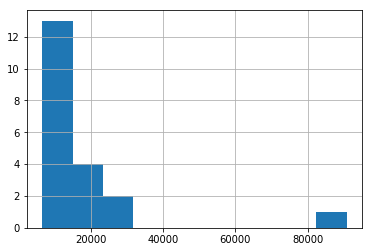

In [0]:
from matplotlib import pyplot as plt
labelpd['count'].hist()
plt.show()

In [0]:
# 영어기호는 feature의 숫자에 속하는 정보인지 확인하기
featuredict = defaultdict(lambda: set([]))
def make_featuredict(x):
  for feature in x.split():
    feature = feature.split('/')
    featuredict[feature[0]].add(feature[1])
df['features'].apply(make_featuredict)
max([len(x) for _,x in featuredict.items()])

1

In [0]:
df['features_len'] = df['features'].apply(lambda x: len(x.split()))
df.head()

,id,labels,features,features_len
0,7510,0,33/nc 60/nc 1531/nc 373/num 539/nbu 28/nc 36/n...,37
1,4344,0,1494/nc 10215/nc 3339/con 10216/nq 1494/nc 102...,14
2,2508,0,789/nc 1730/nc 4931/nc 342/nc 677/nc 48/nc 644...,39
3,7067,1 0,57/nc 1547/nc 173/nc 199/num 36/nc 233/nc 198/...,28
4,6471,0,298/nc 1969/nc 298/nc 1969/nc 886/nc 574/nc 10...,10


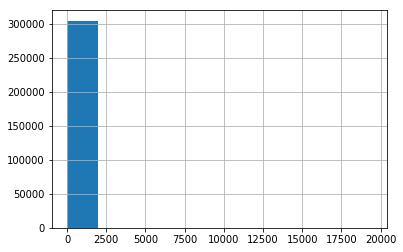

In [0]:
df['features_len'].hist()
plt.show()

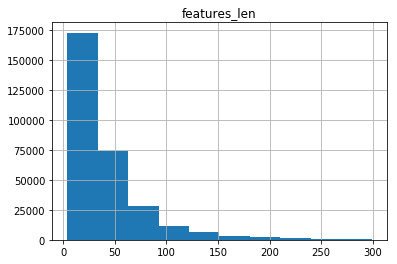

In [0]:
df[df['features_len']<300].hist()
plt.show()

# Code

In [0]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score
#from sklearn.metrics import accuracy_score

Ep = sys.float_info.epsilon

In [0]:
def final_predict2(x):
  re = [0 for i in range(0,len(x))]
  arg = np.array(x).argsort()
  re[arg[-1]] = 1
  for idx in arg[-3:-1]:
    if x[idx] < 1:
      re[idx] = 0
    else:
      re[idx] = 1
  return re

In [0]:
data = open('/gdrive/My Drive/Colab Notebooks/AClassification.train.txt','r').readlines()
data = [line.strip().split('\t') for line in data]
df = pd.DataFrame.from_records(data, columns=['id','labels','features_origin'])
df['features'] = df['features_origin'].apply(lambda x: " ".join([tok.split('/')[0] for tok in x.split(' ')[:300]]))
df['labels'] = df['labels'].apply(lambda x: [int(y) for y in x.split()])
categories = list(range(0, 20))
for i in categories:
  df[i] = df['labels'].apply(lambda x: 1 if i in x else 0)

In [0]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)
x_train = train.features
x_test = test.features
trainedmodel = {}

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train_v = vectorizer.transform(x_train)
x_test_v = vectorizer.transform(x_test)                             

for category in categories:
  SVC_pipeline = Pipeline([
    #('tfidf', TfidfVectorizer(max_df=1.0,ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(C=0.6))),##################
  ])
  LR_pipeline = Pipeline([
    #('tfidf', TfidfVectorizer(max_df=1.0,ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
  ])
  
  print('... Processing {}'.format(category))
  
  print('. SVC')  
  SVC_pipeline.fit(x_train_v, train[category])
  trainedmodel['SVC{}'.format(category)] = SVC_pipeline
  
  print('. LR') 
  LR_pipeline.fit(x_train_v, train[category])
  trainedmodel['LR{}'.format(category)] = LR_pipeline
  
  test['p{}'.format(category)] = np.sum([SVC_pipeline.predict(x_test_v), 
                                         np.array(LR_pipeline.predict_proba(x_test_v))[:,1]], axis=0)

col = ['id','labels','features','features_origin'] + ['p{}'.format(x) for x in range(0,20)]
y_test = test.drop(columns=col)
col = ['id','labels','features','features_origin'] + list(range(0,20))
y_pred = test.drop(columns=col)
y_pred = np.array([res for res in y_pred.apply(lambda x: final_predict2(x), axis=1)])##################

print('f0.5 score {}'.format(fbeta_score(np.array(y_test),np.array(y_pred),0.5,average='micro')))
#f0.5 score 0.8817145413439416

... Processing 0
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 1
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 2
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 3
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 4
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 5
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 6
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 7
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 8
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 9
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 10
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 11
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 12
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 13
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 14
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 15
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 16
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 17
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 18
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


... Processing 19
. SVC
. LR


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


f0.5 score 0.8817145413439416


In [0]:
import pickle
import os
for k, m in trainedmodel.items():
  filename = k+'.bin'
  pickle.dump(m, open(os.path.join('/gdrive/My Drive/Colab Notebooks/models',filename), 'wb'))
  print('Save a model {}'.format(filename))
filename = 'tdidf.bin'
pickle.dump(vectorizer, open(os.path.join('/gdrive/My Drive/Colab Notebooks/models',filename), 'wb'))
print('Save a vectorizer {}'.format(filename))

Save a model SVC0.bin
Save a model LR0.bin
Save a model SVC1.bin
Save a model LR1.bin
Save a model SVC2.bin
Save a model LR2.bin
Save a model SVC3.bin
Save a model LR3.bin
Save a model SVC4.bin
Save a model LR4.bin
Save a model SVC5.bin
Save a model LR5.bin
Save a model SVC6.bin
Save a model LR6.bin
Save a model SVC7.bin
Save a model LR7.bin
Save a model SVC8.bin
Save a model LR8.bin
Save a model SVC9.bin
Save a model LR9.bin
Save a model SVC10.bin
Save a model LR10.bin
Save a model SVC11.bin
Save a model LR11.bin
Save a model SVC12.bin
Save a model LR12.bin
Save a model SVC13.bin
Save a model LR13.bin
Save a model SVC14.bin
Save a model LR14.bin
Save a model SVC15.bin
Save a model LR15.bin
Save a model SVC16.bin
Save a model LR16.bin
Save a model SVC17.bin
Save a model LR17.bin
Save a model SVC18.bin
Save a model LR18.bin
Save a model SVC19.bin
Save a model LR19.bin
Save a vectorizer tdidf.bin


In [0]:
with open('/gdrive/My Drive/Colab Notebooks/test.txt','w') as fw:
  test['features_origin'].apply(lambda x: fw.write(x+'\n'))

In [0]:
!head '/gdrive/My Drive/Colab Notebooks/test.txt'

5364/nc 22097/nc 271/nc 53/nc 3174/nc 5364/nc 285/nc 115/nc 611/nc 4911/nc 4073/nc 38391/nc 22097/nc 20/nc 271/nc
33148/num 682/nbu 61077/nc 23848/nc 719/nbu 33148/num 682/nbu 61077/nc 366/num 1069/nbu 366/num 512/nbu
241/nc 80/num 106844/eng 107331/nc 4151/nc 7416/nc 1586/nc 186/nc 394/nc 259245/nc 259246/nc 104295/nq 14719/nc 240152/nc 240151/nc 111674/nc 5468/nc 176/nc 35625/nq 240151/nc 240152/nc 107331/nc 4151/nc 2626/nc 886/nc 259247/nc 11548/nc 259248/nc 11548/nc 33002/nc 266/num 34829/nc 217837/nc 217837/nc 761/asc 5404/eng 2642/nc 50155/nc 1597/nc
13334/nc 5803/nc 473/nc 13334/nc 55830/nc 5364/nc 5364/nc 285/nc 44573/nc 13334/nc 5803/nc 13334/nc 9172/nn 36906/nc 4491/nc 5364/nc 6361/nc 13334/nc 80/num 388/nbu 4073/nc 36906/nc 2630/nc 33972/nc 1271/nc 13650/nc 476/nc 477/nc 21/nc 271/nc
1479/nc 2005/nc 11671/eng 7210/eng 228528/eng 17814/eng 1284/eng 997/eng 12835/eng 1058/eng 228577/eng 4614/eng 40430/eng 257939/eng 228297/eng 4614/eng 997/eng 232546/eng 227450/eng 205302/eng 

In [0]:
!ls '/gdrive/My Drive/Colab Notebooks/models'

LR0.bin   LR15.bin  LR2.bin  LR8.bin	SVC13.bin  SVC19.bin  SVC6.bin
LR10.bin  LR16.bin  LR3.bin  LR9.bin	SVC14.bin  SVC1.bin   SVC7.bin
LR11.bin  LR17.bin  LR4.bin  SVC0.bin	SVC15.bin  SVC2.bin   SVC8.bin
LR12.bin  LR18.bin  LR5.bin  SVC10.bin	SVC16.bin  SVC3.bin   SVC9.bin
LR13.bin  LR19.bin  LR6.bin  SVC11.bin	SVC17.bin  SVC4.bin   tdidf.bin
LR14.bin  LR1.bin   LR7.bin  SVC12.bin	SVC18.bin  SVC5.bin


### Prediction

In [0]:
import pickle
import os
from collections import defaultdict

def load_from_bin(argpath):
  print('...load models...')
  trainedmodel = {}
  for filename in os.listdir(argpath):
    trainedmodel[filename[:-4]] = 0
    pickle.dump(trainedmodel[filename[:-4]], open(filename, "wb"))
  return trainedmodel

def predict_from_text(datapath, modelpath, vectorizer='tdidf',classnum=20):
  trainedmodel = load_from_bin(modelpath)
  df = pd.DataFrame.from_records(open(datapath,'r').readlines(), columns=['features'])
  df['features'] = df['features'].apply(lambda x: " ".join([tok.split('/')[0] for tok in x.split(' ')[:300]]))
  categories = list(range(0, classnum))

  x_test_v = trainedmodel[vectorizer].transform(df.features)                             

  for category in categories:
    SVC_pipeline = trainedmodel['SVC{}'.format(category)]
    LR_pipeline = trainedmodel['LR{}'.format(category)]

    df['p{}'.format(category)] = np.sum([SVC_pipeline.predict(x_test_v),
                                         np.array(LR_pipeline.predict_proba(x_test_v))[:,1]], axis=0)

  y_pred = df.drop(columns=['features'])
  y_pred = np.array([res for res in y_pred.apply(lambda x: final_predict2(x), axis=1)])

  y_pred['labels'] = y_pred.apply(lambda x: " ".join(numpy.where(np.array(x) > 1)), axis=1)
  y_pred['labels'].apply(lambda x: print(x))
  
  return y_pred
  
col = ['id','labels','features','features_origin']
y_test = test.drop(columns=col)
  
y_pred_from_text = predict_from_text('/gdrive/My Drive/Colab Notebooks/test.txt','/gdrive/My Drive/Colab Notebooks/models')
print('f0.5 score {}'.format(fbeta_score(np.array(y_test),np.array(y_pred_from_text),0.5,average='micro')))

...load models...


# More


### OOV
1.   wordpiece : 이미 숫자 id가 있는 정보이기 때문에 나누는 의미가 없음
1.   품사 정보 사용하기?



### Prediction

1.   test 파일 읽는 predict 만들기 



### Train

1.   tfidfVectorizer 중복 개선 -> 개선되었으나 저장 필요
1.   교차검증으로 하이퍼파라미터 튜닝
1.   앙상블
2.   Lidge, Lasso, Tree, XGboost 등 모델 비교 
1.   Chain, Algorithm Method
1.   품사 정보 합친 버전, 빈도수 많은 id 제한 버전 비교
1.   연속성 정보 살리기 : RNN Test (ing) -> 빈도수에 따른 전처리 버전 비교



### EDA

1. label density
2. class 간 유사도




### Study

1.   모델 별 특성
2.   Multi-label Classification 특성
1.   F0.5 Score 특성
1.   sklearn 함수들 특성 


